# Part 2 - Q2

# q2.a)

In [1]:
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
from itertools import combinations
import random
import struct
from statsmodels.distributions.empirical_distribution import ECDF

rng = np.random.default_rng(seed=22197823)
random.seed(22197823)

In [2]:
def load_files(filenames):
    n = len(filenames)
    data = np.zeros(shape=(n, 40, 40, 40))
    for im_num, filename in enumerate(filenames):
        with open(filename, 'rb') as f:
            # Read the binary data in little-endian format
            file_data = f.read()
            # Convert the binary data to a list of little-endian floats
            floats = list(struct.unpack('<' + 'f' * (len(file_data) // 4), file_data))
        im = np.array(floats).reshape((40,40,40))
        data[im_num] = im
    
    return data

In [3]:
# load all files
filename_CPA_nums = ['04', '05', '06', '07', '08', '09', '10', '11']
filename_PPA_nums = ['03', '06', '09', '10', '13', '14', '15', '16']
filenames_CPA = []
filenames_PPA = []
filenames_mask = ['data/wm_mask.img']
for CPA_num in filename_CPA_nums:
    filenames_CPA.append('data/CPA' + CPA_num + '_diffeo_fa.img')
for PPA_num in filename_PPA_nums:
    filenames_PPA.append('data/PPA' + PPA_num + '_diffeo_fa.img')

data_CPA = load_files(filenames_CPA)
data_PPA = load_files(filenames_PPA)
data_mask = load_files(filenames_mask)[0,:,:,:]

In [4]:
# change voxel data into shape nxm where n is number of samples, and m is number of voxels of interest

# flatten data mask to use as an index on CPA and PPA data. data_mask_flatten is a 1D array
n = data_CPA.shape[0]
data_mask_flatten = data_mask.reshape(-1)

# flatten CPA and PPA data. They are now of shape nxM where M is number of all voxels (40x40x40)
data_CPA_flatten = data_CPA.reshape((n, -1))
data_PPA_flatten = data_PPA.reshape((n, -1))

# only select the voxels of interest to get an array of shape nxm
data_CPA_roi = data_CPA_flatten[:, data_mask_flatten > 0]
data_PPA_roi = data_PPA_flatten[:, data_mask_flatten > 0]

# check that we have selected the correct voxels. Check this by adding all relevant voxels from
# original data array and compare with summing all selected voxels
original_direct_sum = np.einsum('ijkl,jkl->i', data_CPA, data_mask).sum() + np.einsum('ijkl,jkl->i', data_PPA, data_mask).sum()
converted_sum = data_CPA_roi.sum() + data_PPA_roi.sum()
print(f'check the correct roi voxels have been picked. Sum should be zero : {original_direct_sum - converted_sum}')

check the correct roi voxels have been picked. Sum should be zero : 0.0


In [5]:
def calculate_t_statistic(Y, X, lmbda, is_max_only=False, Px=None, M=None):
    """given a Y of many voxels, and X design matrix and contrast vector lmbda return
    the t_statistic for all voxels

    Args:
        Y (ndarray - shape [nxv]): n is number of observations, v is number of voxels
        X (ndarray - shape [nx2]): design matrix
        lmbda (ndarray - shape [2x1]): contrast vector
    
    return:
        t_statistic (ndarray - shape [v]): t_statistic for each voxel
    """
    if Px is None:
        Px = X @ np.linalg.pinv(X.T @ X) @ X.T

    d = Px.shape[0]
    I = np.identity(d)
    Rx = (I - Px)
    error_hat = Rx @ Y
    
    if M is None:
        M = np.linalg.pinv(X.T @ X)
    
    beta = M @ X.T @ Y

    numerator = np.einsum('ji,ij->j', error_hat.T, error_hat)
    denominator = d - np.linalg.matrix_rank(X)
    var_hat = numerator / denominator

    S_beta = np.einsum('i,jk->jki', var_hat, M)

    numerator_all = (lmbda.T @ beta).flatten()
    L = np.einsum('ij,jkl->ikl', lmbda.T, S_beta)
    denominator_all = np.sqrt(np.einsum('ijk,jl->k', L, lmbda))

    t_statistic = (numerator_all / denominator_all)
    
    if is_max_only:
        return t_statistic.max()
    else:
        return t_statistic

In [6]:
N_1 = 8
N_2 = 8
# put it in the form of GLM
Y = np.vstack((data_CPA_roi, data_PPA_roi))

# create design matrix. X[i] is design matrix for voxel i
X = np.zeros(shape=(Y.shape[0], 2))
X[:N_1, 0] = 1
X[N_1:, 1] = 1

print(f'rank of X is: {np.linalg.matrix_rank(X)}')

rank of X is: 2


In [7]:
# create contrast vector lmbda
lmbda = np.array([1,-1])
lmbda = lmbda.reshape((2,1))
lmbda

# calculate the t-statistic
t_statistic_roi = calculate_t_statistic(Y, X, lmbda)

print(f'Max t_statistic on all voxels: {t_statistic_roi.max():.2f}')

Max t_statistic on all voxels: 6.53


# q2.b)

In [8]:
# Find all permutations of the indexs of group 1 and group 2, with each group being size 8
def find_all_group_perm_idxs(N_1, N_2):
    N = int(special.comb(N_1 + N_2, N_1))
    group_idxs = np.arange(N_1 + N_2)
    group_perms_idxs = np.zeros((N, N_1 + N_2))

    for row, group1_perm in enumerate(combinations(group_idxs, N_1)):
        # for the group 1 permutation, store it as group 1 for this row in D_group_perm
        group1_perm = np.asarray(group1_perm)
        group_perms_idxs[row, :N_1] = group1_perm
        
        # for any item not in the group 1 permutation then add it to group 2
        group2_idx = N_1
        for item in group_idxs:
            if item not in group1_perm:
                group_perms_idxs[row, group2_idx] = item
                group2_idx += 1
    return np.int32(group_perms_idxs)

In [9]:
group_perm_idxs = find_all_group_perm_idxs(N_1, N_2)
group_perm_idxs.shape


(12870, 16)

In [10]:
total_perms_num = group_perm_idxs.shape[0]
t_statistic_perms_max = np.zeros(total_perms_num)

# pre calculate the inverse matrixes which don't change with each permutation
M = np.linalg.pinv(X.T @ X)
Px = X @ M @ X.T

for row, perm in enumerate(group_perm_idxs):
    Y_perm = Y[perm, :]
    t_statistic_perms_max[row] = calculate_t_statistic(Y_perm, X, lmbda, is_max_only=True, M=M, Px=Px)
    if row % 1000 == 0:
        print(f'done {((row / total_perms_num)*100):.0f}%')
print('done 100%')

done 0%
done 8%
done 16%
done 23%
done 31%
done 39%
done 47%
done 54%
done 62%
done 70%
done 78%
done 85%
done 93%
done 100%


# q2.c)

In [11]:
t_statistic_max_gt = t_statistic_roi.max()
num_t_stat_more_extreme = (t_statistic_perms_max >= t_statistic_max_gt).sum()
total_t_stat_num = t_statistic_perms_max.shape[0]

p_val = num_t_stat_more_extreme / total_t_stat_num

print(f'Total number of max t-statistics : {total_t_stat_num}')
print(f'Number of max t-stats equally or more extreme than original labeling : {num_t_stat_more_extreme}')
print(f'This gives a p-val of : {p_val:.4f}')

Total number of max t-statistics : 12870
Number of max t-stats equally or more extreme than original labeling : 1182
This gives a p-val of : 0.0918


# q2.d)

In [12]:
# find the 95-th percentile max t-stat to find the threshold for
# 5% p-val
sorted_max_t_stat = np.sort(t_statistic_perms_max)
thresh_idx = int(0.95 * total_t_stat_num)
t_stat_thresh_5pct = sorted_max_t_stat[thresh_idx]
print(f'Threshold for maximum t-stat for a corresponding 5% p-value : {t_stat_thresh_5pct:.5f}')

Threshold for maximum t-stat for a corresponding 5% p-value : 6.93826


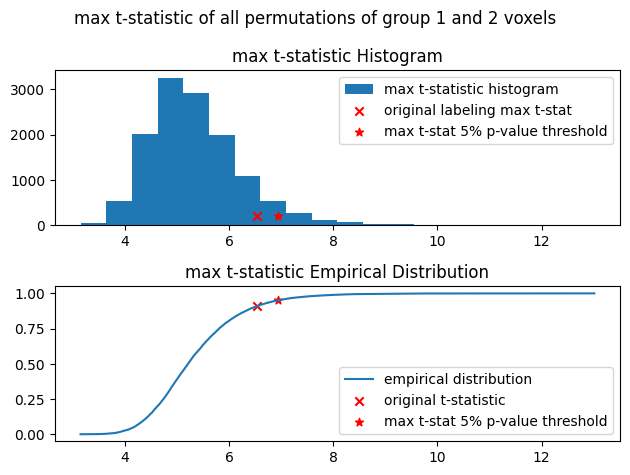

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=1)
fig.suptitle('max t-statistic of all permutations of group 1 and 2 voxels')

axs[0].hist(t_statistic_perms_max, bins=20, label='max t-statistic histogram')
axs[0].scatter(x=t_statistic_max_gt, y=200, color='r', marker='x', label='original labeling max t-stat')
axs[0].scatter(x=t_stat_thresh_5pct, y=200, color='r', marker='*', label='max t-stat 5% p-value threshold')
axs[0].set_title('max t-statistic Histogram')
axs[0].legend()

t_max_ecdf = ECDF(t_statistic_perms_max)
axs[1].plot(np.sort(t_statistic_perms_max), t_max_ecdf(np.sort(t_statistic_perms_max)), label='empirical distribution')
axs[1].scatter(t_statistic_max_gt, t_max_ecdf(t_statistic_max_gt), marker='x', color='r', label='original t-statistic')
axs[1].scatter(x=t_stat_thresh_5pct, y=t_max_ecdf(t_stat_thresh_5pct), color='r', marker='*', label='max t-stat 5% p-value threshold')
axs[1].set_title('max t-statistic Empirical Distribution')
axs[1].legend()

fig.tight_layout()